## Подключение бибилиотек


Сегментация изображения – это метод, при котором цифровое изображение разбивается на различные подгруппы, называемые сегментами изображения, что помогает уменьшить сложность изображения и упростить дальнейшую обработку или анализ изображения. Сегментация – это присвоение меток пикселям. Все элементы изображения или пиксели, принадлежащие к одной и той же категории, имеют общую метку.

In [1]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import time, random, gdown, os
from PIL import Image
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q "/content/drive/MyDrive/airplane_456x256.zip" -d "/content/airplane_456x256"

## Загрузка датасета

In [ ]:
gdown.download('airplane_456x256.zip', None, quiet=True)

'airplane_456x256.zip'

In [ ]:
# Распаковка архива

!unzip -qo airplane_456x256.zip

In [4]:
# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT = 456              # Высота картинки
CLASS_COUNT = 2               # Количество классов на изображении
TRAIN_DIRECTORY = 'airplane_456x256/train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'airplane_456x256/val'         # Название папки с файлами проверочной выборки

In [5]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')):

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))

    # Вывод времени загрузки картинок выборки
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title,
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list))

    return image_list

In [6]:
# Функция для просмотра изображений из набора

def show_imageset(image_list,
                  n
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))


    for i in range(n):
        img = random.choice(image_list)
        axs[i].axis('off')
        axs[i].imshow(img)
    plt.show()

In [7]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.37 с
Количество изображений: 931
Проверочная выборка загружена. Время загрузки: 0.02 с
Количество изображений: 50


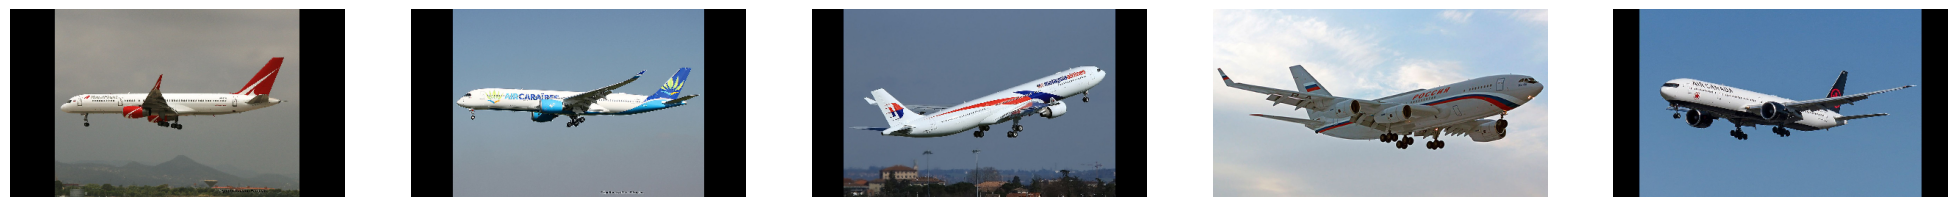

In [8]:
# Просмотр входных изображений из обучающего набора

show_imageset(train_images, 5)

In [9]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.23 с
Количество изображений: 931
Проверочная выборка загружена. Время загрузки: 0.01 с
Количество изображений: 50


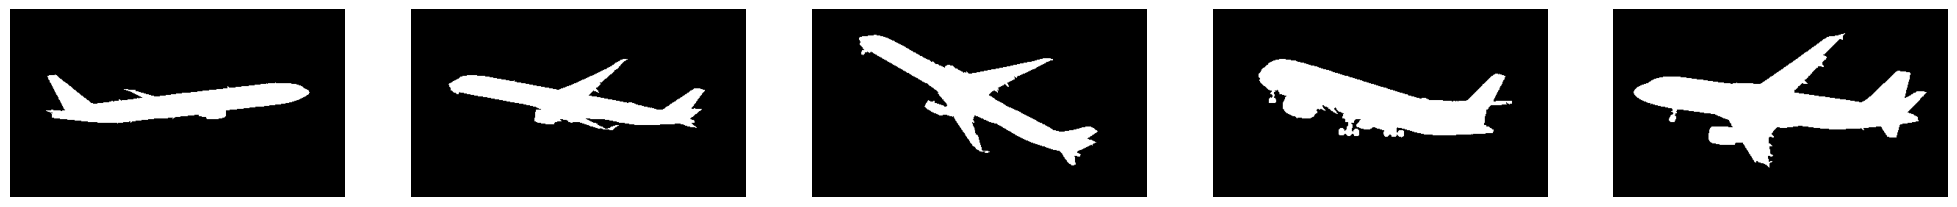

In [10]:
# Просмотр сегментированных изображений из обучающего набора

show_imageset(train_segments, 5)

In [11]:
# Цвета пикселов сегментированных изображений

AIRPLANE = (255, 255, 255)      # Самолет (белый)
BACKGROUND = (0, 0, 0)          # Фон (черный)

In [12]:
CLASS_LABELS = (AIRPLANE, BACKGROUND)

## Создание выборки

Переведем сегментированные изображения в одноканальные сегментированные с номером класса в каждом пикселе :

In [13]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)

        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

        result.append(y)

    return np.array(result)

Обратная функция, перевод одноканальных сегментированных изображений с номером класса в каждом пикселе в 3х канальное RGB сегментированное изображение:

In [14]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений
                 ):

    result = []
    for y in image_list:
            temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
            for i, cl in enumerate(CLASS_LABELS):
                temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

                result.append(temp)

    return np.array(result)

In [15]:
# Формирование обучающей выборки

x_train = []

for img in train_images:
    x = image.img_to_array(img)
    x_train.append(x)

x_train = np.array(x_train)
print(x_train.shape)

(931, 256, 456, 3)


In [16]:
# Формирование проверочной выборки

x_val = []

for img in val_images:
    x = image.img_to_array(img)
    x_val.append(x)

x_val = np.array(x_val)
print(x_val.shape)

(50, 256, 456, 3)


In [17]:
# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(931, 256, 456, 1)
(50, 256, 456, 1)


## Простая линейная (последовательная) архитектура

In [ ]:
def sequential_segmentation_net(class_count,
                                input_shape
                                ):

    img_input = Input(input_shape)
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv5')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)


    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])


    return model

In [ ]:


model_seq = sequential_segmentation_net(CLASS_COUNT,
                                       (IMG_WIDTH, IMG_HEIGHT, 3))

model_seq.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 456, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 456, 128)     3584      
                                                                 
 batch_normalization_4 (Batc  (None, 256, 456, 128)    512       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 256, 456, 128)     0         
                                                                 
 block1_conv3 (Conv2D)       (None, 256, 456, 64)      73792     
                                                                 
 batch_normalization_5 (Batc  (None, 256, 456, 64)     256       
 hNormalization)                                           

In [ ]:
history = model_seq.fit(x_train, y_train,
                        epochs=50, batch_size=32,
                        validation_data=(x_val, y_val))

Epoch 1/50
30/30 [==============================] - 14s 460ms/step - loss: 0.3350 - sparse_categorical_accuracy: 0.9070 - val_loss: 0.9132 - val_sparse_categorical_accuracy: 0.3676
Epoch 2/50
30/30 [==============================] - 14s 454ms/step - loss: 0.2350 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.5141 - val_sparse_categorical_accuracy: 0.7640
Epoch 3/50
30/30 [==============================] - 14s 453ms/step - loss: 0.1970 - sparse_categorical_accuracy: 0.9443 - val_loss: 0.4059 - val_sparse_categorical_accuracy: 0.8805
Epoch 4/50
30/30 [==============================] - 14s 454ms/step - loss: 0.1742 - sparse_categorical_accuracy: 0.9493 - val_loss: 0.3702 - val_sparse_categorical_accuracy: 0.8646
Epoch 5/50
30/30 [==============================] - 14s 455ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.9524 - val_loss: 0.2894 - val_sparse_categorical_accuracy: 0.9028
Epoch 6/50
30/30 [==============================] - 14s 454ms/step - loss: 0.1439 - sparse_cate

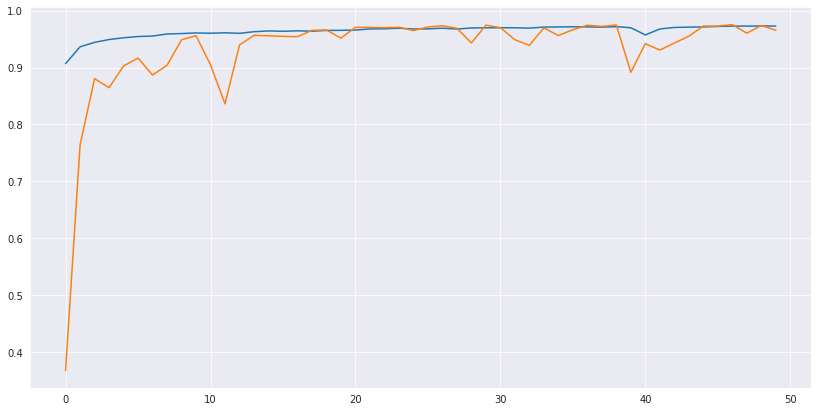

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

In [ ]:
# Функция визуализации процесса сегментации изображений

def process_images(model,
                   count=1,
                   indexes=None,
                   ):

    if indexes is None:
        indexes = np.random.randint(0, len(x_val), count)
    else:
        count = len(indexes)


    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)


    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 10))

    # Отрисовка результата работы модели
    for i in range(count):

        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')


        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show()

**Распознавание**

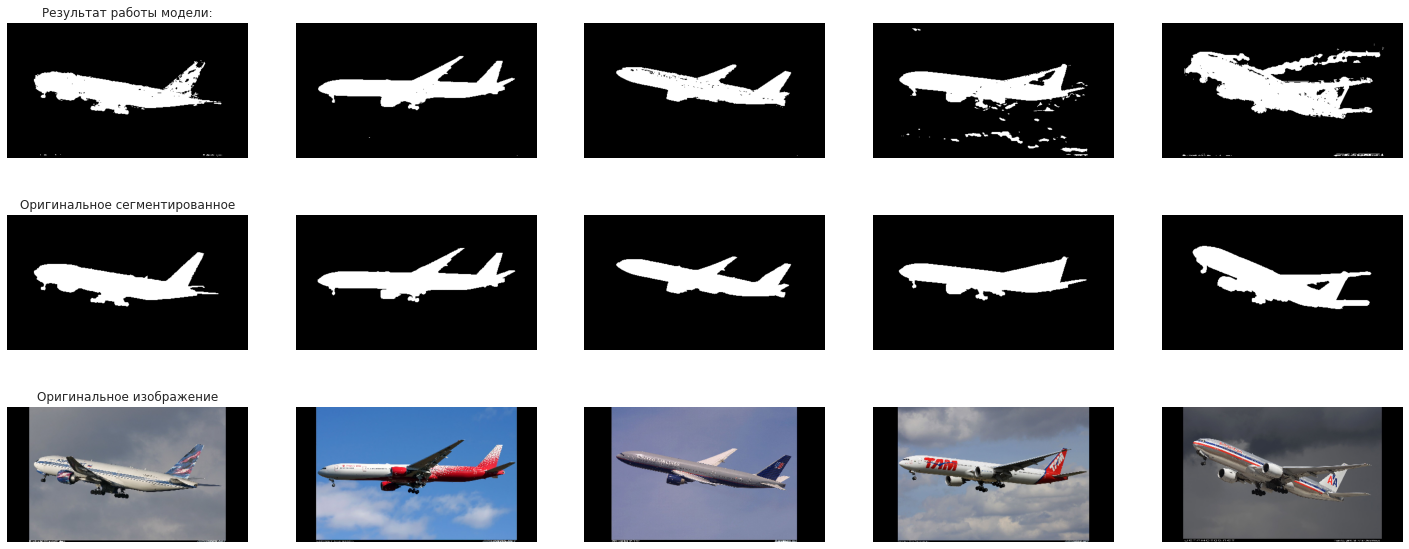

In [ ]:
# Отображение результатов работы модели

process_images(model_seq, 5)

Очень даже неплохо! Теперь мы вправе расчитывать, что получим отличные результаты с более мощной архитектурой, например, **U-Net**.

## Архитектура U-Net

In [ ]:
def unet(class_count,   # количество классов
         input_shape    # форма входного изображения
         ):

    img_input = Input(input_shape)

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         #
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)
    x = block_4_out

    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])


    return model

In [ ]:

model_unet = unet(CLASS_COUNT,
                  (IMG_WIDTH, IMG_HEIGHT, 3))

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 456, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 456, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 456, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 456, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:


history = model_unet.fit(x_train, y_train,
                         epochs=50, batch_size=12,
                         validation_data=(x_val, y_val))

Epoch 1/50
78/78 [==============================] - 67s 604ms/step - loss: 0.1393 - sparse_categorical_accuracy: 0.9584 - val_loss: 0.2807 - val_sparse_categorical_accuracy: 0.8886
Epoch 2/50
78/78 [==============================] - 44s 565ms/step - loss: 0.0448 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.3109 - val_sparse_categorical_accuracy: 0.8796
Epoch 3/50
78/78 [==============================] - 44s 565ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.2005 - val_sparse_categorical_accuracy: 0.9060
Epoch 4/50
78/78 [==============================] - 44s 565ms/step - loss: 0.0276 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.0681 - val_sparse_categorical_accuracy: 0.9744
Epoch 5/50
78/78 [==============================] - 44s 565ms/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9925 - val_loss: 0.0322 - val_sparse_categorical_accuracy: 0.9894
Epoch 6/50
78/78 [==============================] - 44s 565ms/step - loss: 0.0221 - sparse_cate

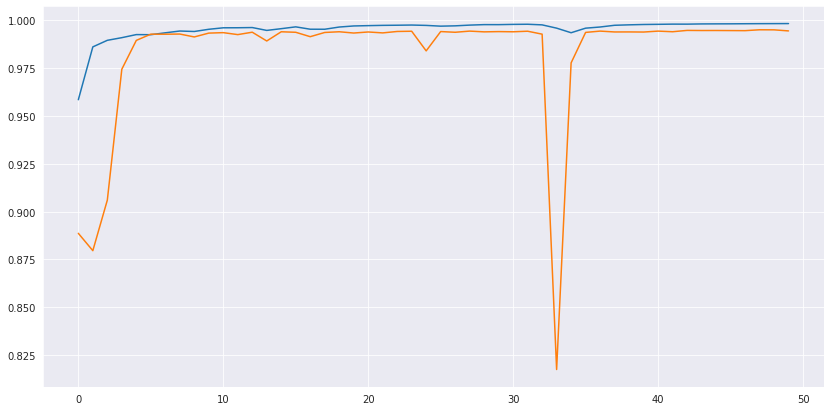

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

**Распознавание**

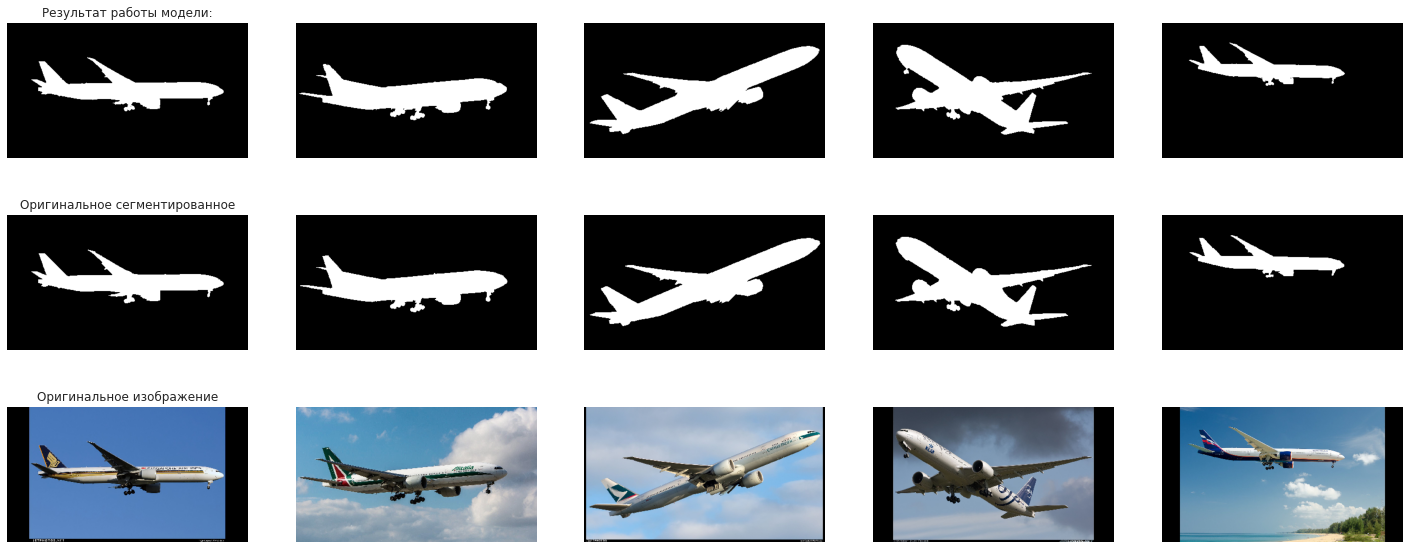

In [ ]:
# Отображение результатов работы модели

process_images(model_unet, 5)



Выведем **5** самых плохих по точности изображений проверочной выборки:

In [ ]:


accuracy = np.array([model_unet.evaluate(x_val[i:i+1],
                                         y_val[i:i+1],
                                         verbose=0)[1] for i in range(x_val.shape[0])])

print(accuracy)

[0.99739581 0.99642783 0.99426055 0.9952457  0.99705321 0.99464601
 0.99560547 0.99642783 0.99213612 0.9972074  0.99869794 0.99594814
 0.99881786 0.99814969 0.97253633 0.99764425 0.99735302 0.99581105
 0.9952628  0.99689901 0.99771279 0.99814111 0.99506581 0.9970789
 0.99605948 0.99895489 0.99719024 0.99487734 0.94459295 0.99817538
 0.99770421 0.99836385 0.99635077 0.98385245 0.99652207 0.98475194
 0.99695897 0.99650496 0.99675333 0.99726737 0.99477452 0.99811542
 0.99758428 0.99568254 0.99418348 0.99722451 0.99665058 0.98673934
 0.99382365 0.99834669]


массив **accuracy**, в котором сохранены значения **val_sparse_categorical_accuracy** для каждого изображения проверочной выборки. Выберем отсюда **5** худших значений:

In [ ]:


print('5 худших по точности сегментации изображений')
bad = np.argsort(accuracy)[:5].tolist()

for b in bad:
    print(f'Изображение №{b} - точность: {accuracy[b]}')

5 худших по точности сегментации изображений
Изображение №28 - точность: 0.9445929527282715
Изображение №14 - точность: 0.9725363254547119
Изображение №33 - точность: 0.9838524460792542
Изображение №35 - точность: 0.9847519397735596
Изображение №47 - точность: 0.9867393374443054


Выведем на экран результаты работы модели на этих изображениях:

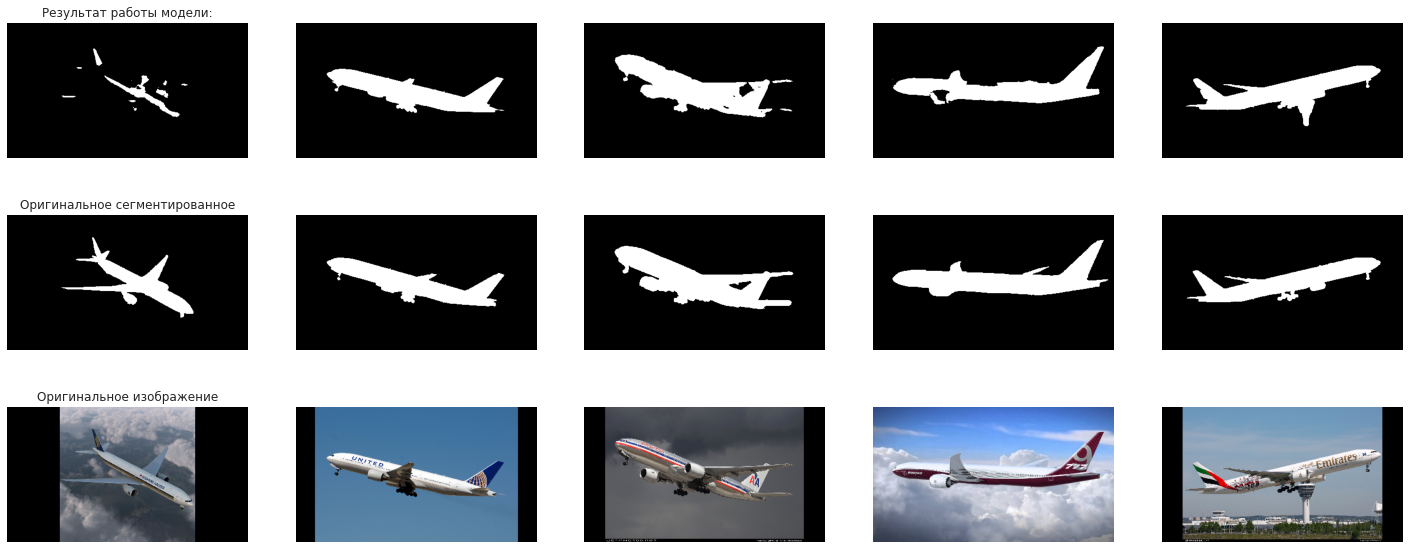

In [ ]:
# Вывод 5 изображений проверочной выборки, на которых модель дает наихудшие результаты

process_images(model_unet, indexes=bad)

**Задание 1. **

1. Создать свою архитектуру сети и решить задачу сегментации.
2. Использовать предобученную сеть и решить задачу сегментации.

# U-Net

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Обучающая выборка загружена. Время загрузки: 2.36 с
Количество изображений: 931
Проверочная выборка загружена. Время загрузки: 0.10 с
Количество изображений: 50


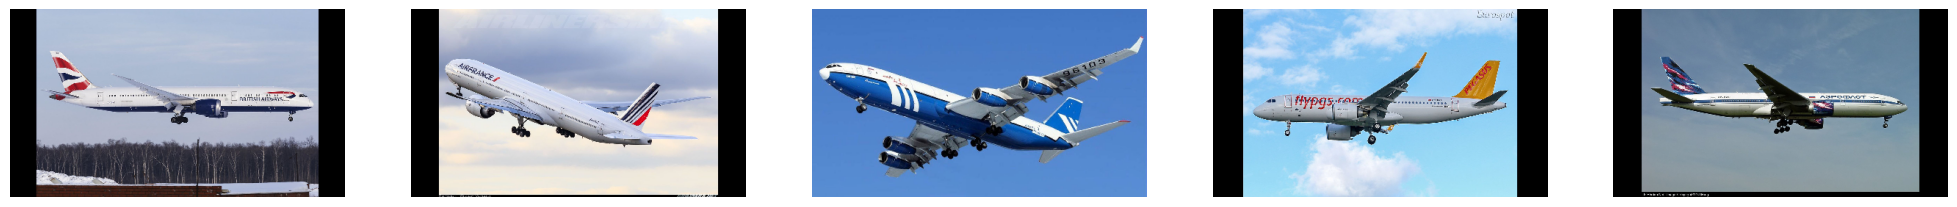

Обучающая выборка загружена. Время загрузки: 0.70 с
Количество изображений: 931
Проверочная выборка загружена. Время загрузки: 0.02 с
Количество изображений: 50


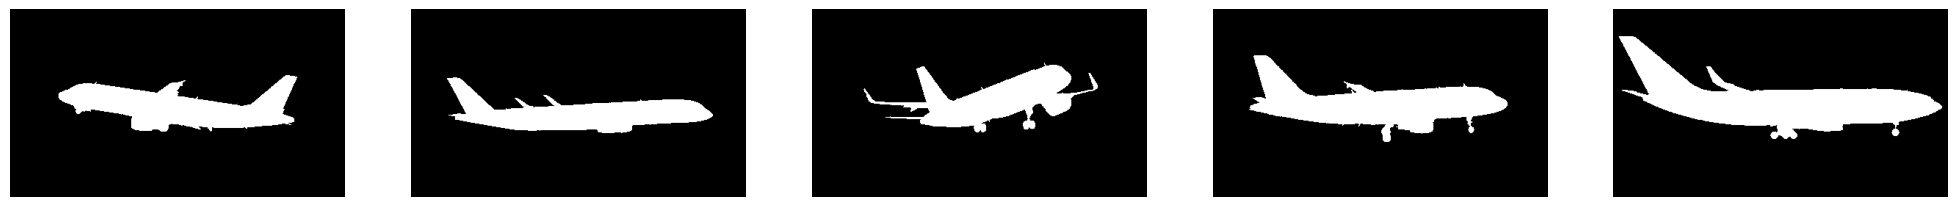

(931, 256, 456, 3)
(50, 256, 456, 3)
(931, 256, 456, 1)
(50, 256, 456, 1)


In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import time, random, gdown, os
from PIL import Image
import seaborn as sns
sns.set_style('darkgrid')

from google.colab import drive
drive.mount('/content/drive')


# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT = 456              # Высота картинки
CLASS_COUNT = 2               # Количество классов на изображении
TRAIN_DIRECTORY = 'airplane_456x256/train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'airplane_456x256/val'         # Название папки с файлами проверочной выборки

# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')):

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))

    # Вывод времени загрузки картинок выборки
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title,time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list))

    return image_list
# Функция для просмотра изображений из набора

def show_imageset(image_list,n):
    fig, axs = plt.subplots(1, n, figsize=(25, 10))

    for i in range(n):
        img = random.choice(image_list)
        axs[i].axis('off')
        axs[i].imshow(img)
    plt.show()
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

# Просмотр входных изображений из обучающего набора

show_imageset(train_images, 5)

# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')
# Просмотр сегментированных изображений из обучающего набора

show_imageset(train_segments, 5)

# Цвета пикселов сегментированных изображений

AIRPLANE = (255, 255, 255)      # Самолет (белый)
BACKGROUND = (0, 0, 0)          # Фон (черный)

CLASS_LABELS = (AIRPLANE, BACKGROUND)

# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)

        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

        result.append(y)

    return np.array(result)

# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений
                 ):

    result = []
    for y in image_list:
            temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
            for i, cl in enumerate(CLASS_LABELS):
                temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

                result.append(temp)

    return np.array(result)

# Формирование обучающей выборки

x_train = []

for img in train_images:
    x = image.img_to_array(img)
    x_train.append(x)

x_train = np.array(x_train)
print(x_train.shape)

# Формирование проверочной выборки

x_val = []

for img in val_images:
    x = image.img_to_array(img)
    x_val.append(x)

x_val = np.array(x_val)
print(x_val.shape)

# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

In [18]:
def build_unet(input_shape=(256, 456, 3), num_classes=2):
    inputs = Input(input_shape)

    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    b = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = BatchNormalization()(b)
    b = Conv2D(128, (3, 3), activation='relu', padding='same')(b)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b)
    u2 = concatenate([u2, c2])
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = concatenate([u1, c1])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c4)

    model = Model(inputs, outputs)
    return model

In [19]:
model = build_unet()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=8, epochs=10)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 456,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 456,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 456,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 456,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 228,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 228,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 228,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 228,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 114,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 114,   │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 114,   │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 114,   │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 228,  │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 228,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 228,  │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 228,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 256, 456,  │      8,224 │ conv2d_7[0][0]  

 Total params: 467,458 (1.78 MB)

 Trainable params: 467,010 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 68s 368ms/step - accuracy: 0.9028 - loss: 0.2124 - val_accuracy: 0.9476 - val_loss: 0.1419
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.9756 - loss: 0.0648 - val_accuracy: 0.9097 - val_loss: 0.1959
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.9806 - loss: 0.0489 - val_accuracy: 0.9798 - val_loss: 0.0544
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.9843 - loss: 0.0414 - val_accuracy: 0.9844 - val_loss: 0.0436
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.9875 - loss: 0.0338 - val_accuracy: 0.9875 - val_loss: 0.0347
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.9863 - loss: 0.0356 - val_accuracy: 0.9854 - val_loss: 0.0418
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.9881 - loss: 0.0320 - val_accuracy: 0.9792 - val_loss: 0.0530
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - accuracy: 0.9893 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


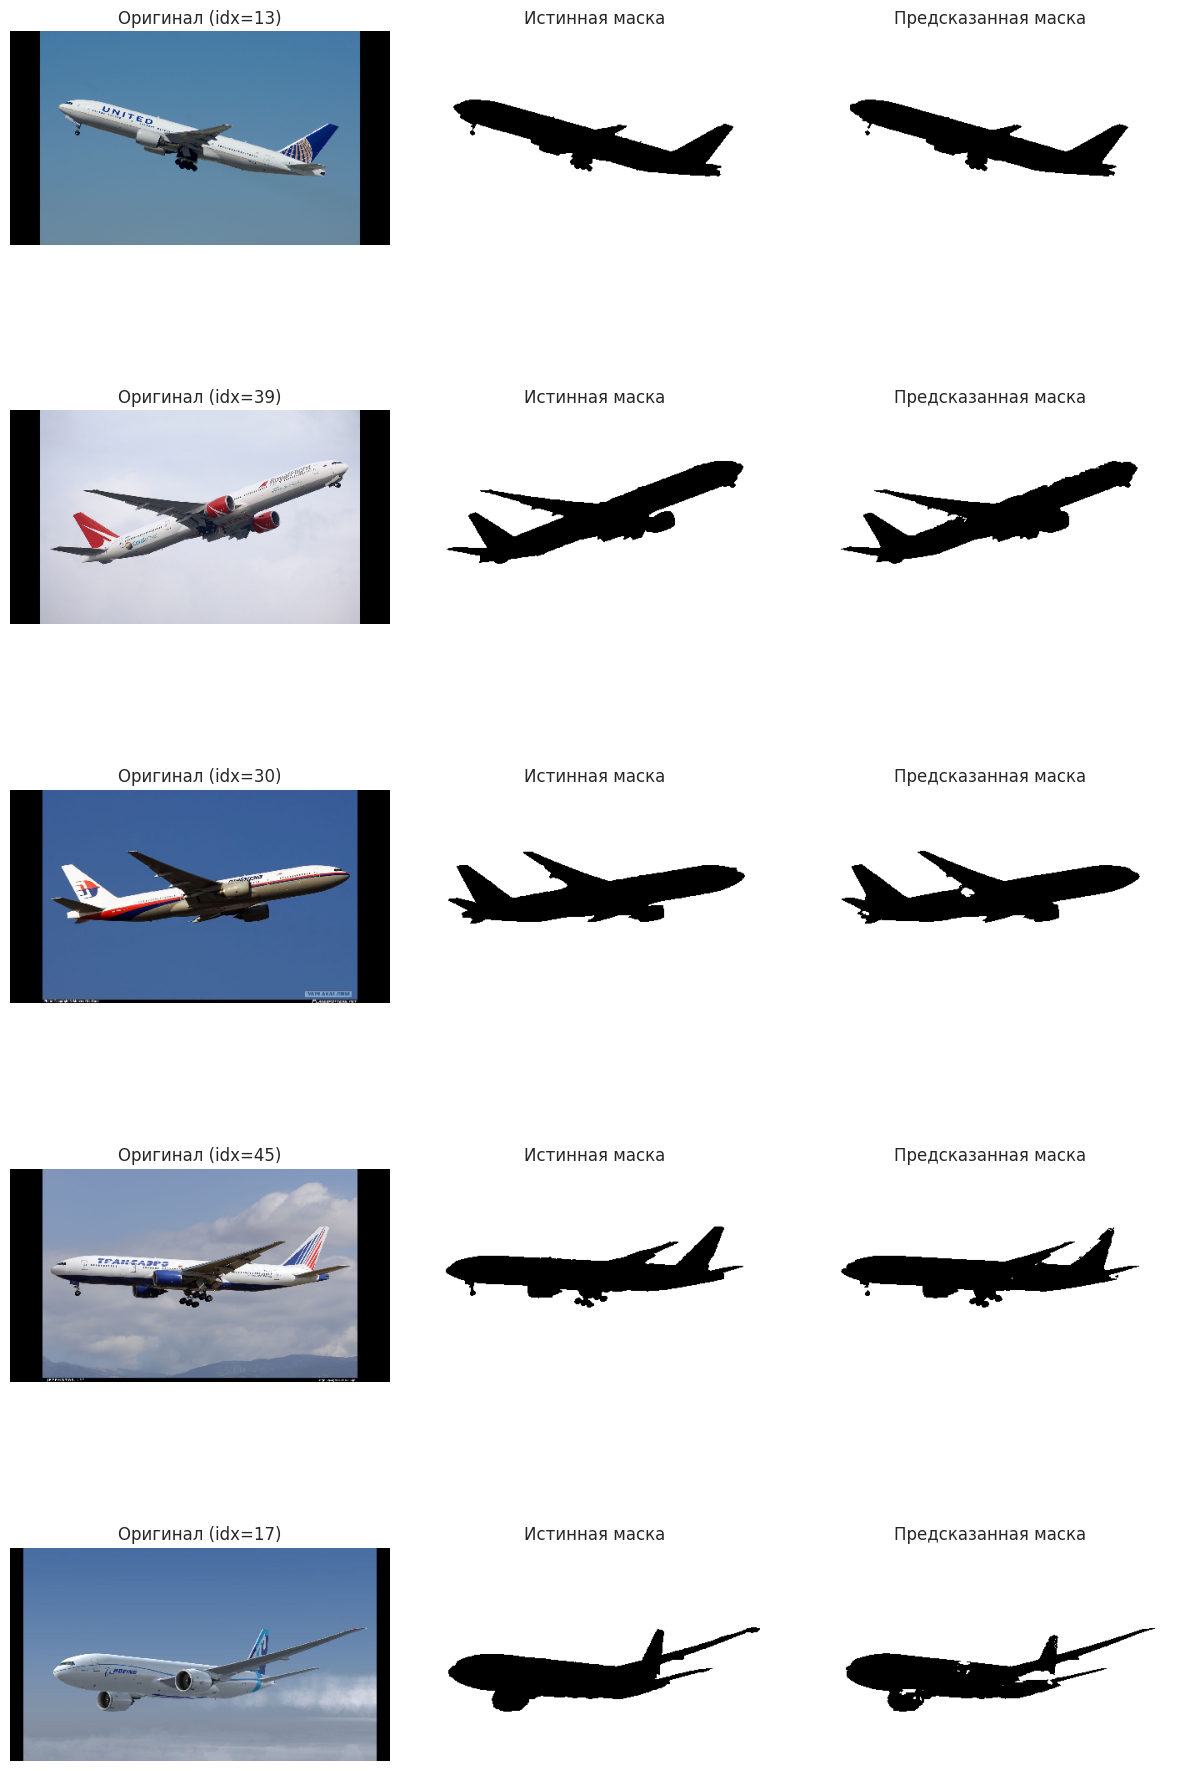

In [25]:
import numpy as np
import matplotlib.pyplot as plt


def plot_segmentation_results(model, x_val, y_val, count=5, random_seed=42):

    np.random.seed(random_seed)
    indices = np.random.choice(len(x_val), size=count, replace=False)

    preds = model.predict(x_val[indices])
    pred_labels = np.argmax(preds, axis=-1)

    true_labels = y_val[indices].squeeze(-1)

    plt.figure(figsize=(12, 4 * count))
    for i, idx in enumerate(indices):
        ax = plt.subplot(count, 3, i * 3 + 1)
        img = x_val[idx]
        if img.dtype != np.uint8:
            img2 = np.clip(img, 0, 255).astype(np.uint8)
        else:
            img2 = img
        ax.imshow(img2)
        ax.set_title(f"Оригинал (idx={idx})")
        ax.axis('off')

        ax = plt.subplot(count, 3, i * 3 + 2)
        ax.imshow(true_labels[i], cmap='gray')
        ax.set_title("Истинная маска")
        ax.axis('off')

        ax = plt.subplot(count, 3, i * 3 + 3)
        ax.imshow(pred_labels[i], cmap='gray')
        ax.set_title("Предсказанная маска")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_segmentation_results(model, x_val, y_val, count=5)

# MobileNet

In [26]:
import cv2
import numpy as np

NEW_W = 448
NEW_H = 256

def resize_images(img_array):
    resized = []
    for img in img_array:
        orig_dtype = img.dtype
        if np.issubdtype(orig_dtype, np.floating):
            tmp = (img * 255).astype(np.uint8)
        else:
            tmp = img.copy()
        tmp = cv2.resize(tmp, (NEW_W, NEW_H), interpolation=cv2.INTER_LINEAR)
        if np.issubdtype(orig_dtype, np.floating):
            tmp = tmp.astype(np.float32) / 255.0
        resized.append(tmp)
    return np.stack(resized, axis=0)

def resize_masks(mask_array):
    resized = []
    for m in mask_array:
        tmp = m.squeeze()
        tmp = (tmp * 255).astype(np.uint8) if tmp.max() <= 1 else tmp
        tmp = cv2.resize(tmp, (NEW_W, NEW_H), interpolation=cv2.INTER_NEAREST)
        tmp = (tmp > 127).astype(np.uint8)
        resized.append(tmp[..., np.newaxis])
    return np.stack(resized, axis=0)

x_train_res = resize_images(x_train)
x_val_res   = resize_images(x_val)
y_train_res = resize_masks(y_train)
y_val_res   = resize_masks(y_val)

In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Conv2D
from tensorflow.keras.models import Model

def build_pretrained_unet(input_shape=(256, 448, 3), num_classes=2):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    skip1 = base_model.get_layer('block_1_expand_relu').output
    skip2 = base_model.get_layer('block_3_expand_relu').output
    skip3 = base_model.get_layer('block_6_expand_relu').output
    encoder_output = base_model.get_layer('block_13_expand_relu').output

    x = encoder_output
    x = Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = concatenate([x, skip3])
    x = Conv2D(256, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = concatenate([x, skip2])
    x = Conv2D(128, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = concatenate([x, skip1])
    x = Conv2D(64, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)

    outputs = Conv2D(num_classes, 1, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [28]:
from tensorflow.keras.optimizers import Adam

x_train_prep = preprocess_input(x_train_res.astype(np.float32) * 255.0)
x_val_prep   = preprocess_input(x_val_res.astype(np.float32)   * 255.0)

model_pretrained = build_pretrained_unet(input_shape=(256, 448, 3), num_classes=2)
model_pretrained.compile(optimizer=Adam(),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

model_pretrained.summary()

history = model_pretrained.fit(x_train_prep, y_train_res.squeeze(-1),
                               validation_data=(x_val_prep, y_val_res.squeeze(-1)),
                               batch_size=8, epochs=20)

<ipython-input-27-e213550cf2b1>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 448,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 224,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 224,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 224,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 224,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 224,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 224,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 224,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 224,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 224,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 224,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 224,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 225,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 112,   │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 112,   │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 112,   │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 112,   │      2,304 │ block_1_depthwis

 Total params: 3,778,370 (14.41 MB)

 Trainable params: 3,162,114 (12.06 MB)

 Non-trainable params: 616,256 (2.35 MB)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 81s 460ms/step - accuracy: 0.9328 - loss: 0.1394 - val_accuracy: 0.9924 - val_loss: 0.0228
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.9925 - loss: 0.0198 - val_accuracy: 0.9879 - val_loss: 0.0330
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.9940 - loss: 0.0162 - val_accuracy: 0.9943 - val_loss: 0.0182
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.9949 - loss: 0.0137 - val_accuracy: 0.9946 - val_loss: 0.0176
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.9953 - loss: 0.0125 - val_accuracy: 0.9946 - val_loss: 0.0171
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.9958 - loss: 0.0110 - val_accuracy: 0.9940 - val_loss: 0.0196
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 0.9962 - loss: 0.0100 - val_accuracy: 0.9948 - val_loss: 0.0164
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.9964 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


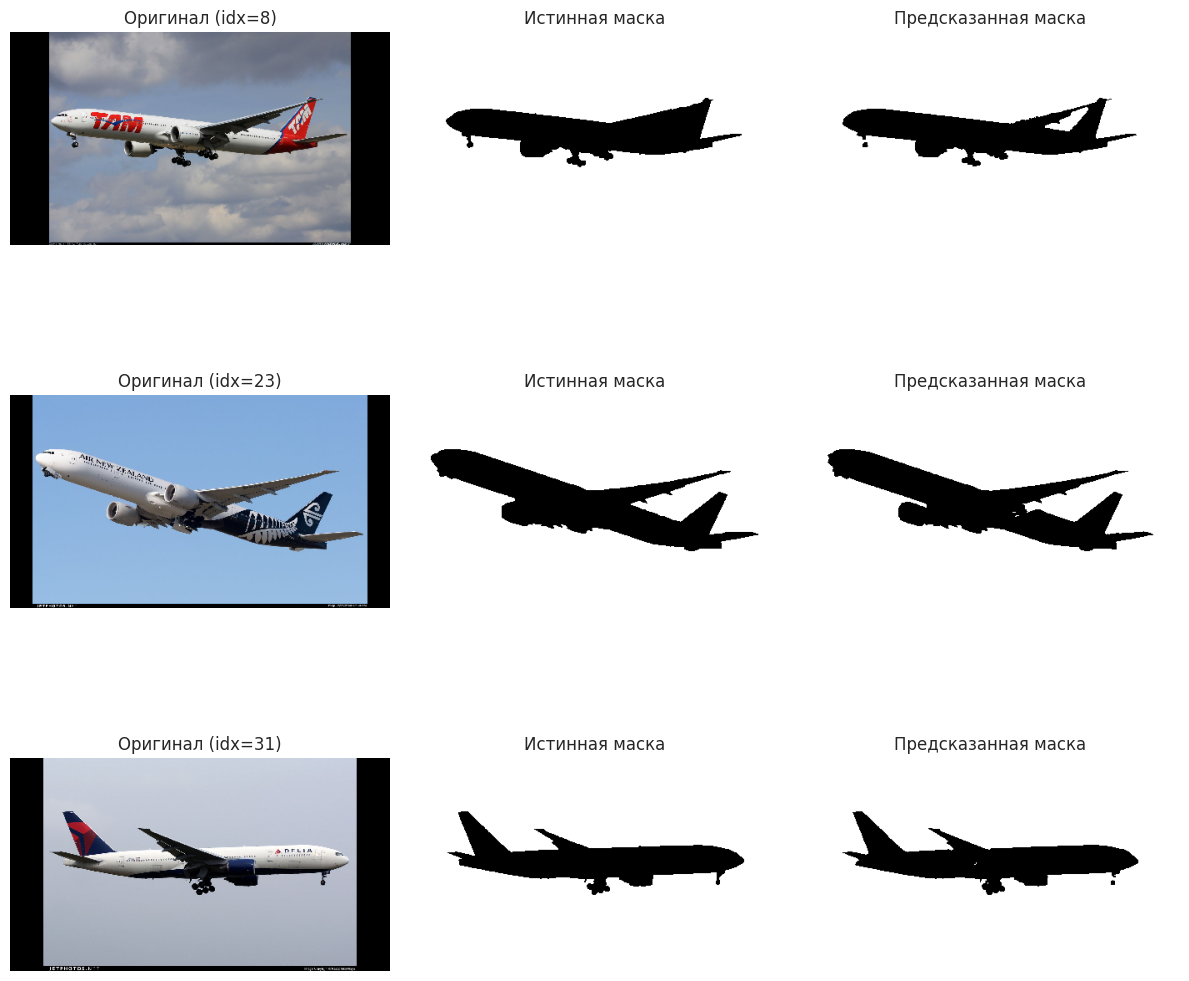

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_segmentation_results(model, x_val, y_val, count=5):
    N_val = x_val.shape[0]
    count = min(count, N_val)

    indices = np.random.choice(N_val, size=count, replace=False)

    preds = model.predict(x_val[indices])
    pred_labels = np.argmax(preds, axis=-1)

    true_labels = y_val[indices].squeeze(-1)

    plt.figure(figsize=(12, 4 * count))
    for i, idx in enumerate(indices):
        ax = plt.subplot(count, 3, i * 3 + 1)
        img = x_val[idx]
        if img.dtype != np.uint8:
            img2 = np.clip(img, 0, 255).astype(np.uint8)
        else:
            img2 = img
        ax.imshow(img2)
        ax.set_title(f"Оригинал (idx={idx})")
        ax.axis('off')

        ax = plt.subplot(count, 3, i * 3 + 2)
        ax.imshow(true_labels[i], cmap='gray')
        ax.set_title("Истинная маска")
        ax.axis('off')

        ax = plt.subplot(count, 3, i * 3 + 3)
        ax.imshow(pred_labels[i], cmap='gray')
        ax.set_title("Предсказанная маска")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_segmentation_results(model, x_val, y_val, count=3)

**Задание 2. **

1. Загрузить датасет Flower.zip решить задачу сегментации.
2. Создать 3 архитектуры сети, вывести графики обучения, вывести лучшую, провести инференс.

In [ ]:
!unzip -q "/content/drive/MyDrive/flowers.zip" -d "/content/flower_data"

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from tqdm import tqdm


extract_path = "/content/flower_data"
img_dir = os.path.join(extract_path, "flowers", "04-matricaria-01", "720p")
mask_dir = os.path.join(extract_path, "flowers", "04-matricaria-01", "mask")

class FlowerSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, mask_transform=None):
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform is not None:
            img = self.transform(img)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
            mask = (mask > 0).float()

        return img, mask

img_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

In [ ]:
dataset = FlowerSegmentationDataset(img_dir, mask_dir, transform=img_transform, mask_transform=mask_transform)
train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset   = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class UNetSimple(nn.Module):
    def __init__(self):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )
        self.enc1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        return torch.sigmoid(out)

class UNetResNet34(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        base_model = models.resnet34(pretrained=pretrained)
        self.conv1  = base_model.conv1
        self.bn1    = base_model.bn1
        self.relu   = base_model.relu
        self.pool0  = base_model.maxpool
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        self.center = conv_block(512, 1024)

        self.up4  = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(512 + 256, 512)

        self.up3  = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(256 + 128, 256)

        self.up2  = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(128 + 64, 128)

        self.up1  = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(64 + 64, 64)

        self.up0  = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.final = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        e0 = self.relu(self.bn1(self.conv1(x)))
        e1 = self.layer1(self.pool0(e0))
        e2 = self.layer2(e1)
        e3 = self.layer3(e2)
        e4 = self.layer4(e3)

        center = self.center(e4)

        d4 = self.up4(center)
        d4 = torch.cat([d4, e3], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e0], dim=1)
        d1 = self.dec1(d1)

        d0 = self.up0(d1)
        out = self.final(d0)
        return torch.sigmoid(out)

class SimpleFCN(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        base_model = models.resnet18(pretrained=pretrained)
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        self.conv = nn.Conv2d(512, 1, 1)
        self.up = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.up(x)
        return torch.sigmoid(x)

In [ ]:
def iou_score(preds, targets, threshold=0.5):
    preds_bin = (preds > threshold).float()
    preds_flat   = preds_bin.view(preds_bin.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)
    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1) - intersection
    iou = torch.where(union == 0, torch.ones_like(intersection), intersection / union)
    return iou.mean().item()

def train_epoch(model, loader, criterion, optimizer, device, epoch, total_epochs):
    model.train()
    running_loss = 0.0
    running_iou  = 0.0
    total_samples = 0

    loop = tqdm(loader, desc=f"Epoch [{epoch}/{total_epochs}] Train", leave=False)
    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        running_iou  += iou_score(outputs, masks) * batch_size
        total_samples += batch_size

        avg_loss = running_loss / total_samples
        avg_iou  = running_iou  / total_samples
        loop.set_postfix({"loss": f"{avg_loss:.4f}", "iou": f"{avg_iou:.4f}"})

    return running_loss / total_samples, running_iou / total_samples

def eval_epoch(model, loader, criterion, device, epoch, total_epochs):
    model.eval()
    running_loss = 0.0
    running_iou  = 0.0
    total_samples = 0

    loop = tqdm(loader, desc=f"Epoch [{epoch}/{total_epochs}] Val  ", leave=False)
    with torch.no_grad():
        for imgs, masks in loop:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)

            batch_size = imgs.size(0)
            running_loss += loss.item() * batch_size
            running_iou  += iou_score(outputs, masks) * batch_size
            total_samples += batch_size

            avg_loss = running_loss / total_samples
            avg_iou  = running_iou  / total_samples
            loop.set_postfix({"loss": f"{avg_loss:.4f}", "iou": f"{avg_iou:.4f}"})

    return running_loss / total_samples, running_iou / total_samples

In [ ]:
def run_training(model, train_loader, val_loader, epochs=15, lr=1e-3):
    print(f"\nЗапускаем обучение на {epochs} эпох.")
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [], "val_loss": [],
        "train_iou":  [], "val_iou":  []
    }

    for epoch in range(1, epochs + 1):
        train_loss, train_iou = train_epoch(model, train_loader, criterion, optimizer, device, epoch, epochs)
        val_loss, val_iou     = eval_epoch(model, val_loader,   criterion, device, epoch, epochs)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_iou"].append(train_iou)
        history["val_iou"].append(val_iou)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train loss: {train_loss:.4f}, IoU: {train_iou:.4f} | "
            f"Val   loss: {val_loss:.4f}, IoU: {val_iou:.4f}"
        )
    return model, history

In [ ]:
models_dict = {
    "UNetSimple": UNetSimple(),
    "UNetResNet34": UNetResNet34(),
    "SimpleFCN": SimpleFCN(),
}

histories = {}
trained_models = {}

for name, model in models_dict.items():
    print(f"\n=== Training {name} ===")
    tm, hist = run_training(model, train_loader, val_loader, epochs=3, lr=1e-3)
    trained_models[name] = tm
    histories[name] = hist


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weig


=== Training UNetSimple ===

Запускаем обучение на 3 эпох.


Epoch 1/3 | Train loss: 0.0313, IoU: 0.9872 | Val   loss: 0.0114, IoU: 0.9843


Epoch 2/3 | Train loss: 0.0042, IoU: 0.9929 | Val   loss: 0.0044, IoU: 0.9935


Epoch 3/3 | Train loss: 0.0033, IoU: 0.9935 | Val   loss: 0.0032, IoU: 0.9937

=== Training UNetResNet34 ===

Запускаем обучение на 3 эпох.


Epoch 1/3 | Train loss: 0.0211, IoU: 0.9834 | Val   loss: 0.0036, IoU: 0.9924


Epoch 2/3 | Train loss: 0.0031, IoU: 0.9935 | Val   loss: 0.0030, IoU: 0.9940


Epoch 3/3 | Train loss: 0.0034, IoU: 0.9930 | Val   loss: 0.0029, IoU: 0.9939

=== Training SimpleFCN ===

Запускаем обучение на 3 эпох.


Epoch 1/3 | Train loss: 0.0919, IoU: 0.8034 | Val   loss: 0.0845, IoU: 0.8116


Epoch 2/3 | Train loss: 0.0838, IoU: 0.8135 | Val   loss: 0.0835, IoU: 0.8149


Epoch 3/3 | Train loss: 0.0833, IoU: 0.8144 | Val   loss: 0.0828, IoU: 0.8129


In [ ]:
best_model_name = max(histories, key=lambda x: max(histories[x]["val_iou"]))
print(f"\n>>> Best model: {best_model_name}")

best_model = trained_models[best_model_name]
best_model.eval()


>>> Best model: UNetResNet34


UNetResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

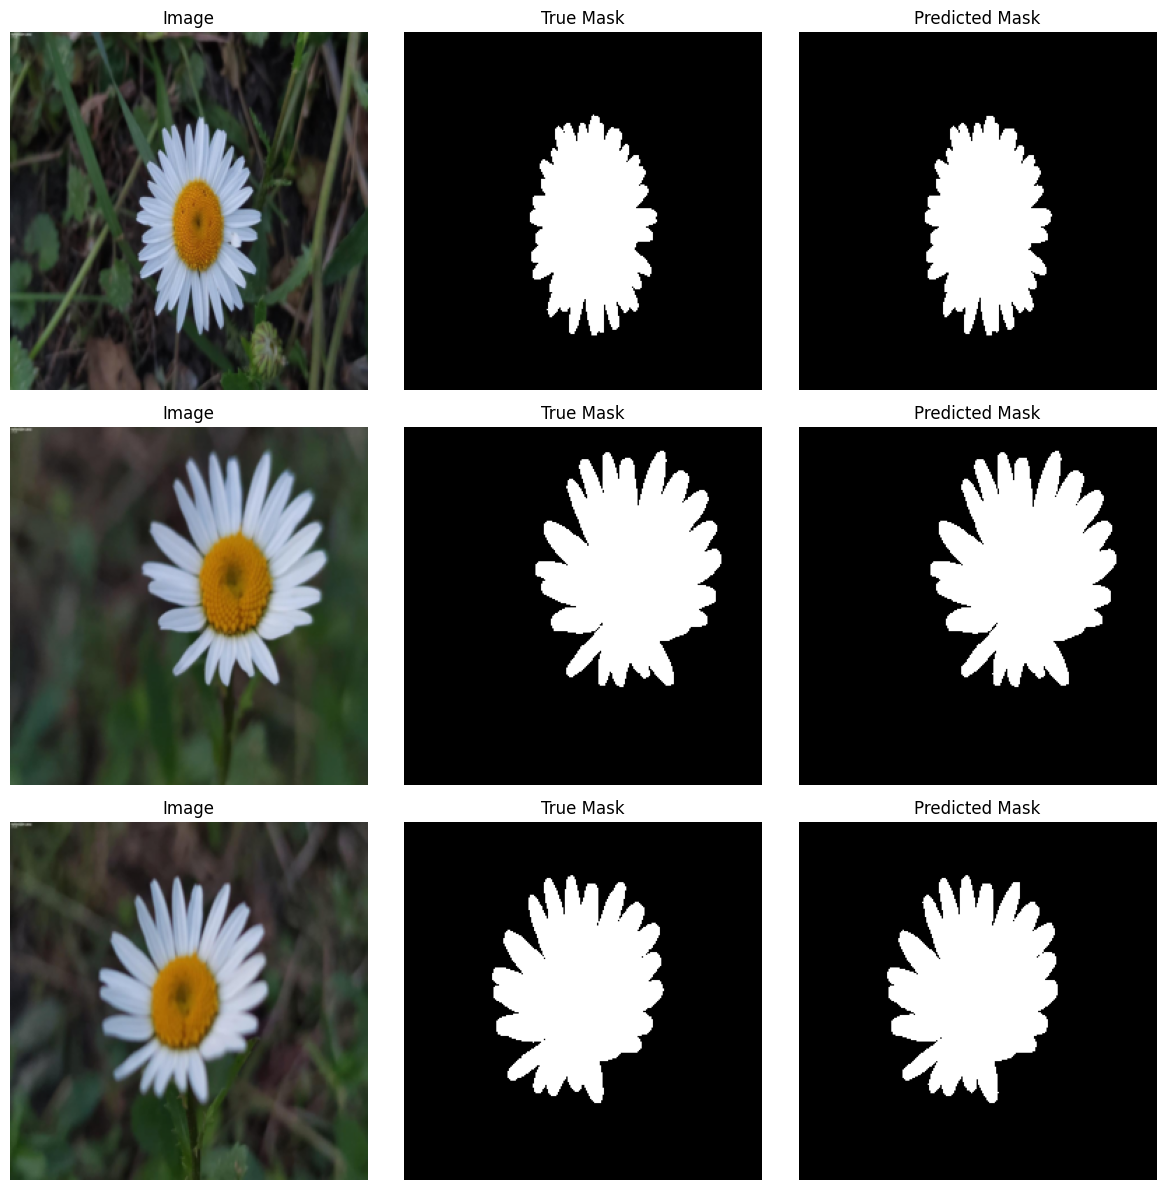

In [ ]:
def visualize_inference(model, dataset, device, n_samples=3):
    model.to(device)
    model.eval()
    plt.figure(figsize=(12, 4 * n_samples))
    for i in range(n_samples):
        img, mask = dataset[i]
        img_batch = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(img_batch)
        pred = pred.squeeze(0).squeeze(0).cpu()
        pred_bin = (pred > 0.5).float()

        plt.subplot(n_samples, 3, i*3 + 1)
        img_np = img.cpu().numpy().transpose(1,2,0)
        img_disp = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
        img_disp = np.clip(img_disp, 0, 1)
        plt.imshow(img_disp)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(n_samples, 3, i*3 + 2)
        plt.imshow(mask.squeeze(0).cpu(), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(pred_bin, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_inference(best_model, val_dataset, device, n_samples=3)